In [731]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/berlin-airbnb-data/listings.csv
/kaggle/input/berlin-airbnb-data/calendar_summary.csv
/kaggle/input/berlin-airbnb-data/reviews.csv
/kaggle/input/berlin-airbnb-data/reviews_summary.csv
/kaggle/input/berlin-airbnb-data/neighbourhoods.csv
/kaggle/input/berlin-airbnb-data/listings_summary.csv


# Objective: Predict Berlin Airbnb prices using Lasso Regulatization and Random Forest XGBoost

This data set has a ton of features, messy data and missing values so is a good dataset for feature engineering and lasso regularization

Data Source/Credit: https://www.kaggle.com/brittabettendorf/berlin-airbnb-data

In [732]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [733]:
! jupyter nbconvert --to html your_notebook_name.ipynb.

[NbConvertApp] WARNING | pattern 'your_notebook_name.ipynb.' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--debug
    set log level to logging.DEBUG (maximize logging output)
--generate-config
    generate default config file
-y
    Answer yes to any questions instead of prompting.
--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--stdout
    Write notebook output 

In [734]:
#load data
data = pd.read_csv('../input/berlin-airbnb-data/listings_summary.csv')
data.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20181107122246,2018-11-07,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,...,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,4,3.76
1,2695,https://www.airbnb.com/rooms/2695,20181107122246,2018-11-07,Prenzlauer Berg close to Mauerpark,NaN,In the summertime we are spending most of our ...,In the summertime we are spending most of our ...,none,NaN,...,t,NaN,NaN,f,f,flexible,f,f,1,1.42
2,3176,https://www.airbnb.com/rooms/3176,20181107122246,2018-11-07,Fabulous Flat in great Location,This beautiful first floor apartment is situa...,1st floor (68m2) apartment on Kollwitzplatz/ P...,This beautiful first floor apartment is situa...,none,The neighbourhood is famous for its variety of...,...,t,NaN,NaN,t,f,strict_14_with_grace_period,f,f,1,1.25
3,3309,https://www.airbnb.com/rooms/3309,20181107122246,2018-11-07,BerlinSpot Schöneberg near KaDeWe,First of all: I prefer short-notice bookings. ...,"Your room is really big and has 26 sqm, is ver...",First of all: I prefer short-notice bookings. ...,none,"My flat is in the middle of West-Berlin, direc...",...,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0.39
4,7071,https://www.airbnb.com/rooms/7071,20181107122246,2018-11-07,BrightRoom with sunny greenview!,Cozy and large room in the beautiful district ...,"The BrightRoom is an approx. 20 sqm (215ft²), ...",Cozy and large room in the beautiful district ...,none,"Great neighborhood with plenty of Cafés, Baker...",...,t,NaN,NaN,f,f,moderate,f,f,1,1.75


In [735]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Data columns (total 96 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                22552 non-null  int64  
 1   listing_url                       22552 non-null  object 
 2   scrape_id                         22552 non-null  int64  
 3   last_scraped                      22552 non-null  object 
 4   name                              22493 non-null  object 
 5   summary                           21589 non-null  object 
 6   space                             14020 non-null  object 
 7   description                       22349 non-null  object 
 8   experiences_offered               22552 non-null  object 
 9   neighborhood_overview             11540 non-null  object 
 10  notes                             7215 non-null   object 
 11  transit                           13036 non-null  object 
 12  acce

Remove redundant or irrelevant columns, keeping %NAN in mind (if majority are missing, consider whether imputing or deleting the entire column makes more sense).

We can also remove constant variables, meaning variables that only have the same one value for the entire dataset, as these will not provide any additional information to predict the price. For example,"has_availability" is the same value "t" for all 22,552 entries so we can remove that entire column. We can also remove country code, as all properties are in Germany. 

In [736]:
#asses NaN count and Nan%
round(data.isnull().sum()/len(data),3)

id                                  0.000
listing_url                         0.000
scrape_id                           0.000
last_scraped                        0.000
name                                0.003
                                    ...  
cancellation_policy                 0.000
require_guest_profile_picture       0.000
require_guest_phone_verification    0.000
calculated_host_listings_count      0.000
reviews_per_month                   0.174
Length: 96, dtype: float64

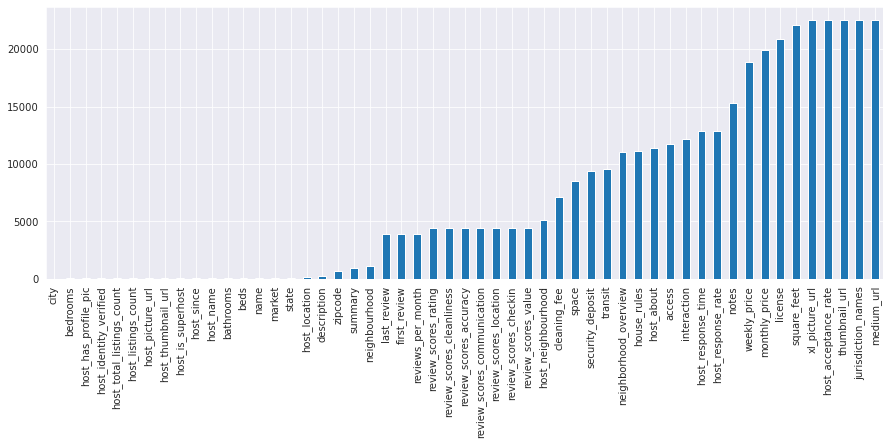

In [737]:

with sns.axes_style("darkgrid"):
    plt.figure(figsize=(15,5))
    missing = data.isnull().sum()
    missing = missing[missing > 0]
    missing.sort_values(inplace=True)
    missing.plot.bar()

In [738]:
#drop columns
data.drop(['neighbourhood_cleansed','host_since','host_has_profile_pic','city','host_listings_count','is_business_travel_ready','has_availability','state','country_code','street','zipcode','host_response_time','host_response_rate','host_neighbourhood','experiences_offered','first_review','last_review','calendar_updated','amenities','is_location_exact','country','smart_location','market','host_location','host_verifications','review_scores_accuracy','host_name','review_scores_cleanliness','listing_url','scrape_id','description','transit','access','interaction','house_rules','last_scraped','summary','space','neighborhood_overview','availability_30','availability_60','availability_90','availability_365','calendar_last_scraped','jurisdiction_names','notes','thumbnail_url','medium_url','picture_url','xl_picture_url','host_url','host_about','host_thumbnail_url','host_picture_url','name','license','square_feet','weekly_price','monthly_price','neighbourhood','host_acceptance_rate','reviews_per_month','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','requires_license','calculated_host_listings_count'], axis=1, inplace=True)

In [739]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                22552 non-null  int64  
 1   host_id                           22552 non-null  int64  
 2   host_is_superhost                 22526 non-null  object 
 3   host_total_listings_count         22526 non-null  float64
 4   host_identity_verified            22526 non-null  object 
 5   neighbourhood_group_cleansed      22552 non-null  object 
 6   latitude                          22552 non-null  float64
 7   longitude                         22552 non-null  float64
 8   property_type                     22552 non-null  object 
 9   room_type                         22552 non-null  object 
 10  accommodates                      22552 non-null  int64  
 11  bathrooms                         22520 non-null  float64
 12  bedr

In [740]:
round(data.isnull().sum()/len(data),4)

id                                  0.0000
host_id                             0.0000
host_is_superhost                   0.0012
host_total_listings_count           0.0012
host_identity_verified              0.0012
neighbourhood_group_cleansed        0.0000
latitude                            0.0000
longitude                           0.0000
property_type                       0.0000
room_type                           0.0000
accommodates                        0.0000
bathrooms                           0.0014
bedrooms                            0.0008
beds                                0.0018
bed_type                            0.0000
price                               0.0000
security_deposit                    0.4151
cleaning_fee                        0.3169
guests_included                     0.0000
extra_people                        0.0000
minimum_nights                      0.0000
maximum_nights                      0.0000
number_of_reviews                   0.0000
review_scor

In [741]:
data.nunique()

id                                  22552
host_id                             19180
host_is_superhost                       2
host_total_listings_count              31
host_identity_verified                  2
neighbourhood_group_cleansed           12
latitude                            22552
longitude                           22552
property_type                          33
room_type                               3
accommodates                           16
bathrooms                              16
bedrooms                               12
beds                                   18
bed_type                                5
price                                 295
security_deposit                      142
cleaning_fee                          112
guests_included                        15
extra_people                           65
minimum_nights                        102
maximum_nights                        222
number_of_reviews                     306
review_scores_rating              

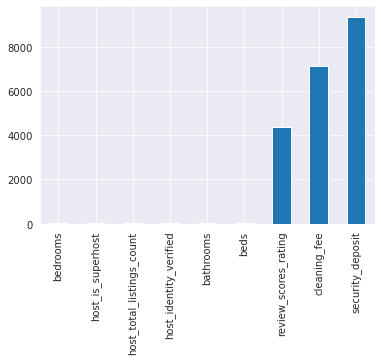

In [742]:
with sns.axes_style("darkgrid"):
    missing = data.isnull().sum()
    missing = missing[missing > 0]
    missing.sort_values(inplace=True)
    missing.plot.bar()

We need to impute values for the columns that have NaNs - see columns below

In [743]:
missing = data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing

bedrooms                       18
host_is_superhost              26
host_total_listings_count      26
host_identity_verified         26
bathrooms                      32
beds                           40
review_scores_rating         4389
cleaning_fee                 7146
security_deposit             9361
dtype: int64

# Data Cleaning

We'll need to do some quick data cleaning and data type conversions before conducting some EDA analysis. 

In [744]:
#convert price data type 
data.price = data.price.str.replace('$', '').str.replace(',', '').astype(float)

In [745]:
#convert cleaning fee data type
data.cleaning_fee = data.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)

In [746]:
#convert security deposit data type
data.security_deposit = data.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)

In [747]:
#convert extra people data type
data.extra_people = data.extra_people.str.replace('$', '').str.replace(',', '').astype(float)

# Exploratiory Data Analysis

# Univariate Analysis (Price)

Univariate analysis helps us understand the distribution and patterns of the target variable (price) 

In [748]:
#let's make sure price(our target) doesn't have any missing values
data.price.isnull().sum()

0

In [749]:
#Price distribution (check for outliers)
data.price.describe()

count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

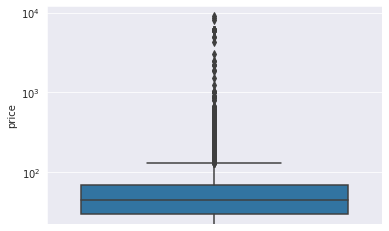

In [750]:
import scipy.stats as st
with sns.axes_style("darkgrid"):
    ax = sns.boxplot(data['price'], orient='v')
    ax.set_yscale("log")

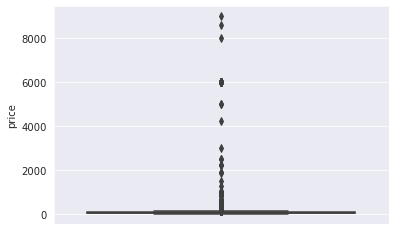

In [751]:
with sns.axes_style("darkgrid"):
    ax = sns.boxplot(data['price'], orient='v')


In [752]:
data[(data['price'] == 0)]
data[(data['price'] > 300)]
data.price.quantile(0.99)

print(data.shape)
data.drop(data[data.price == 0].index, axis=0, inplace=True)
print(data.shape)
data.drop(data[data.price > 300].index, axis=0, inplace=True)
print(data.shape)

(22552, 28)
(22544, 28)
(22379, 28)


There are 8 records with 0 listed as the price. The max value is 900. Based on the boxplots, it is apparent that there are a significant number of outliers. I'd like to set the boundary to $300, which is a little above the 99% quantile, given the extremity of the outliers. We woulld lose 165 rows of data, however the size of the dataset is large enough to support this. 

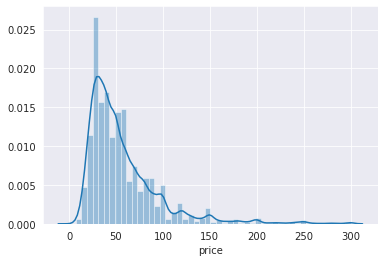

In [753]:
with sns.axes_style("darkgrid"):
    ax = sns.distplot(data['price'], norm_hist=True)

In [754]:
print(data.price.mode())
print(data.price.describe())

0    30.0
dtype: float64
count    22379.000000
mean        56.737298
std         38.990777
min          1.000000
25%         30.000000
50%         45.000000
75%         70.000000
max        300.000000
Name: price, dtype: float64


# Multivariate Analysis 

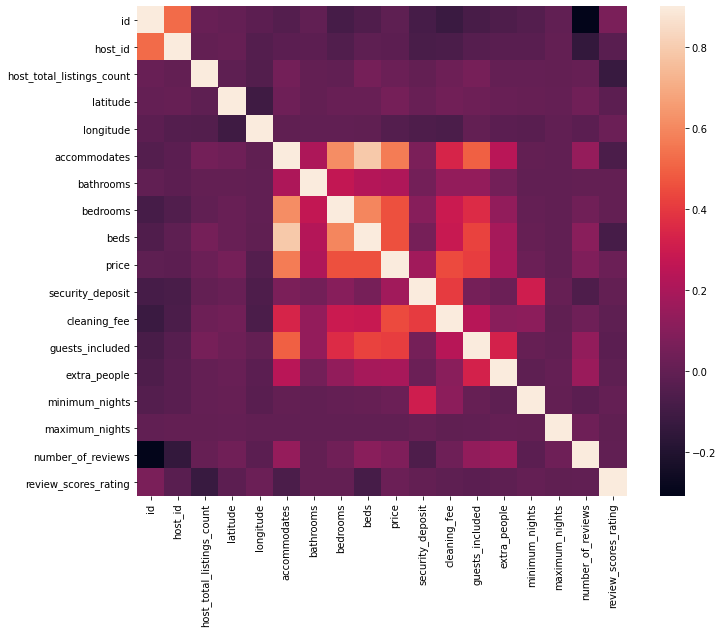

In [755]:
#correlation matrix

corr = data.corr()
f, ax = plt.subplots(figsize= (12,9))
sns.heatmap(corr, vmax=0.9, square=True)

# Data Transformation and Imputing Missing Values

Before we implement mean and mode imputation, we need to split our data set into train and test sets. When we impute the mean, we must only calculate the mean from the train test and then impute it into both the train and test set. The reason this is important is that if we calculate the mean from the entire data set, it will contribute to data leakage. 

In [756]:
missing = data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing

bedrooms                       18
host_is_superhost              25
host_total_listings_count      25
host_identity_verified         25
bathrooms                      32
beds                           38
review_scores_rating         4316
cleaning_fee                 7069
security_deposit             9302
dtype: int64

In [757]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22379 entries, 0 to 22551
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                22379 non-null  int64  
 1   host_id                           22379 non-null  int64  
 2   host_is_superhost                 22354 non-null  object 
 3   host_total_listings_count         22354 non-null  float64
 4   host_identity_verified            22354 non-null  object 
 5   neighbourhood_group_cleansed      22379 non-null  object 
 6   latitude                          22379 non-null  float64
 7   longitude                         22379 non-null  float64
 8   property_type                     22379 non-null  object 
 9   room_type                         22379 non-null  object 
 10  accommodates                      22379 non-null  int64  
 11  bathrooms                         22347 non-null  float64
 12  bedr

We can drop the rows for everthing other than "review_scores_rating", "cleaning_fee" and "security_deposit" where we have missing values as there are not many of them. 

In [758]:
data.shape

(22379, 28)

In [759]:
data.dropna(subset =["bedrooms","host_is_superhost","host_total_listings_count","host_identity_verified","bathrooms","beds"], inplace=True)

In [760]:
data.shape

(22276, 28)

Split the data into separate training and test set 

In [761]:
from sklearn.model_selection import train_test_split

X = data.drop(['price'], axis=1)
y = data[['price']]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)

In [762]:
X_train.shape, X_test.shape

((17820, 27), (4456, 27))

In [763]:
X_train["cleaning_fee"].mean()

26.286684115818748

In [764]:
for df in [X_train,X_test]:
   df['review_scores_rating'].fillna(X_train['review_scores_rating'].mean(),inplace=True)
   df['cleaning_fee'].fillna(X_train['cleaning_fee'].mean(), inplace=True)
   df['security_deposit'].fillna(X_train['security_deposit'].mean(), inplace=True)
    

In [765]:
X_train.isnull().sum()
X_test.isnull().sum()

id                                  0
host_id                             0
host_is_superhost                   0
host_total_listings_count           0
host_identity_verified              0
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
beds                                0
bed_type                            0
security_deposit                    0
cleaning_fee                        0
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating                0
instant_bookable                    0
cancellation_policy                 0
require_guest_profile_picture       0
require_gues

In [766]:
X_train.head()

,id,host_id,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,...,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
10505,15863714,5574002,f,1.0,t,Treptow - Köpenick,52.492426,13.447739,Apartment,Entire home/apt,...,1,10.0,4,12,5,100.000000,t,strict_14_with_grace_period,f,f
11257,16836582,38170846,f,2.0,t,Friedrichshain-Kreuzberg,52.511712,13.453688,Apartment,Private room,...,1,0.0,4,20,1,80.000000,f,moderate,f,f
15307,21149883,40355262,f,3.0,t,Mitte,52.550636,13.367156,Apartment,Private room,...,1,5.0,3,11,0,94.395162,f,flexible,f,f
17108,22793805,39101255,f,1.0,t,Neukölln,52.466077,13.431780,Apartment,Private room,...,1,0.0,3,4,2,100.000000,f,flexible,f,f
9909,14821817,92645586,f,4.0,f,Tempelhof - Schöneberg,52.479381,13.344497,Apartment,Entire home/apt,...,2,25.0,1,1125,117,86.000000,f,moderate,f,f


In [767]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17820 entries, 10505 to 2786
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                17820 non-null  int64  
 1   host_id                           17820 non-null  int64  
 2   host_is_superhost                 17820 non-null  object 
 3   host_total_listings_count         17820 non-null  float64
 4   host_identity_verified            17820 non-null  object 
 5   neighbourhood_group_cleansed      17820 non-null  object 
 6   latitude                          17820 non-null  float64
 7   longitude                         17820 non-null  float64
 8   property_type                     17820 non-null  object 
 9   room_type                         17820 non-null  object 
 10  accommodates                      17820 non-null  int64  
 11  bathrooms                         17820 non-null  float64
 12  b

Encode categorical variables

In [768]:
import category_encoders as ce

encoder = ce.OneHotEncoder(cols = ['host_is_superhost','host_identity_verified','neighbourhood_group_cleansed','property_type','room_type','bed_type','instant_bookable','cancellation_policy','require_guest_profile_picture','require_guest_phone_verification'])

X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

In [769]:
print(X_train.shape, X_test.shape)

(17820, 83) (4456, 83)


In [770]:
cols = X_train.columns

from sklearn.preprocessing import StandardScaler

sc= StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

X_train.head()

,id,host_id,host_is_superhost_1,host_is_superhost_2,host_total_listings_count,host_identity_verified_1,host_identity_verified_2,neighbourhood_group_cleansed_1,neighbourhood_group_cleansed_2,neighbourhood_group_cleansed_3,...,instant_bookable_2,cancellation_policy_1,cancellation_policy_2,cancellation_policy_3,cancellation_policy_4,cancellation_policy_5,require_guest_profile_picture_1,require_guest_profile_picture_2,require_guest_phone_verification_1,require_guest_phone_verification_2
0,0.014237,-0.834337,0.390039,-0.390039,-0.061556,1.255048,-1.255048,6.016852,-0.568883,-0.505518,...,-1.481256,1.608402,-0.681893,-0.818598,-0.045614,-0.022479,0.082683,-0.082683,0.108938,-0.108938
1,0.128184,-0.271807,0.390039,-0.390039,-0.016758,1.255048,-1.255048,-0.166200,1.757831,-0.505518,...,0.675103,-0.621735,1.466505,-0.818598,-0.045614,-0.022479,0.082683,-0.082683,0.108938,-0.108938
2,0.633377,-0.234110,0.390039,-0.390039,0.028040,1.255048,-1.255048,-0.166200,-0.568883,1.978169,...,0.675103,-0.621735,-0.681893,1.221600,-0.045614,-0.022479,0.082683,-0.082683,0.108938,-0.108938
3,0.825920,-0.255751,0.390039,-0.390039,-0.061556,1.255048,-1.255048,-0.166200,-0.568883,-0.505518,...,0.675103,-0.621735,-0.681893,1.221600,-0.045614,-0.022479,0.082683,-0.082683,0.108938,-0.108938
4,-0.107794,0.668275,0.390039,-0.390039,0.072838,-0.796783,0.796783,-0.166200,-0.568883,-0.505518,...,0.675103,-0.621735,1.466505,-0.818598,-0.045614,-0.022479,0.082683,-0.082683,0.108938,-0.108938


# Model Implementation

# Random Forest 

In [771]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

rfr = RandomForestRegressor()

rfr.fit(X_train,y_train)
rfr_pred = rfr.predict(X_test)

print(r2_score(y_test,rfr_pred))
print(np.sqrt(mean_squared_error(y_test,rfr_pred)))

0.6175131015461822
24.308387673099773


Let's see if we can improve by training the model with gradient boosting (XGBoost)

In [772]:
import xgboost as xgb

xgbr = xgb.XGBRegressor()

param_grid = {'n_estimators': [100, 200, 300],
              'learning_rate': [0.01, 0.05, 0.1],
              'max_depth': [3,4,6]} 

xgbr_grid_search = GridSearchCV(xgbr, param_grid, cv = 3, n_jobs = 1)

xgbr_grid_search.fit(X_train, y_train)

print(xgbr_grid_search.best_params_)

{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300}


In [773]:
xgbr = xgb.XGBRegressor(learning_rate=0.05, max_depth=6, n_estimators=300, random_state=4)

xgbr.fit(X_train, y_train)

xgbr_pred = xgbr.predict(X_test)

print(r2_score(y_test,xgbr_pred))
print(np.sqrt(mean_squared_error(y_test,xgbr_pred)))

0.6462909356912363
23.37604134921772


# Feature Importance

In [774]:
X_train.head()

,id,host_id,host_is_superhost_1,host_is_superhost_2,host_total_listings_count,host_identity_verified_1,host_identity_verified_2,neighbourhood_group_cleansed_1,neighbourhood_group_cleansed_2,neighbourhood_group_cleansed_3,...,instant_bookable_2,cancellation_policy_1,cancellation_policy_2,cancellation_policy_3,cancellation_policy_4,cancellation_policy_5,require_guest_profile_picture_1,require_guest_profile_picture_2,require_guest_phone_verification_1,require_guest_phone_verification_2
0,0.014237,-0.834337,0.390039,-0.390039,-0.061556,1.255048,-1.255048,6.016852,-0.568883,-0.505518,...,-1.481256,1.608402,-0.681893,-0.818598,-0.045614,-0.022479,0.082683,-0.082683,0.108938,-0.108938
1,0.128184,-0.271807,0.390039,-0.390039,-0.016758,1.255048,-1.255048,-0.166200,1.757831,-0.505518,...,0.675103,-0.621735,1.466505,-0.818598,-0.045614,-0.022479,0.082683,-0.082683,0.108938,-0.108938
2,0.633377,-0.234110,0.390039,-0.390039,0.028040,1.255048,-1.255048,-0.166200,-0.568883,1.978169,...,0.675103,-0.621735,-0.681893,1.221600,-0.045614,-0.022479,0.082683,-0.082683,0.108938,-0.108938
3,0.825920,-0.255751,0.390039,-0.390039,-0.061556,1.255048,-1.255048,-0.166200,-0.568883,-0.505518,...,0.675103,-0.621735,-0.681893,1.221600,-0.045614,-0.022479,0.082683,-0.082683,0.108938,-0.108938
4,-0.107794,0.668275,0.390039,-0.390039,0.072838,-0.796783,0.796783,-0.166200,-0.568883,-0.505518,...,0.675103,-0.621735,1.466505,-0.818598,-0.045614,-0.022479,0.082683,-0.082683,0.108938,-0.108938


Text(0.5, 1.0, 'Feature Importance using XGBoost')

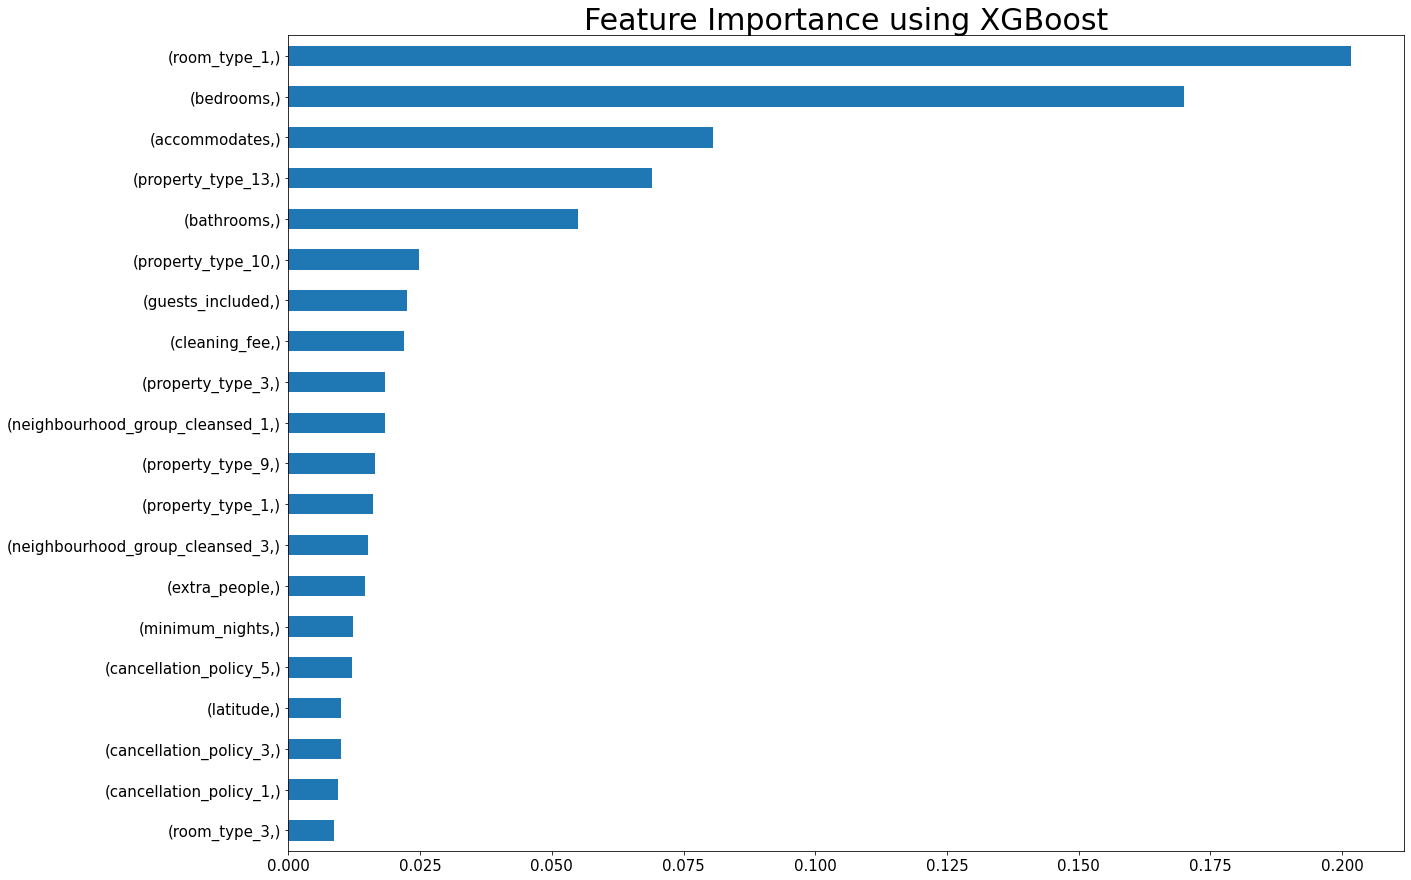

In [775]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
ax = pd.Series(xgbr.feature_importances_, index=X_train.columns)

ax.nlargest(20).sort_values().plot(kind='barh', figsize= (20,15), fontsize=15)
plt.title('Feature Importance using XGBoost', fontsize=30)


# Lasso Regularization

In [776]:
from sklearn.linear_model import Lasso

Lasso_reg = Lasso()
parameters = {'alpha' :[x for x in [0.01, 0.1, 0.2, 0.3, 0.5, 0.7,1]]}

Lasso_reg = GridSearchCV(Lasso_reg, param_grid=parameters)
Lasso_reg.fit(X_train,y_train)

print(Lasso_reg.best_params_)

{'alpha': 0.5}


In [777]:
Lasso_reg = Lasso(alpha=0.1)
Lasso_reg.fit(X_train,y_train)
Lasso_pred_train = Lasso_reg.predict(X_train)
Lasso_pred_test = Lasso_reg.predict(X_test)

print(r2_score(y_test,Lasso_pred_test))
print((np.sqrt(mean_squared_error(y_train,Lasso_pred_train))))
print((np.sqrt(mean_squared_error(y_test,Lasso_pred_test))))

0.5230960124418924
27.33428876697248
27.143343889800203


# Conclusions & Next Steps 

The Random Forest & XGBoost model performed better than Lasso, however given the size of RMSE (Root Mean Square Error) and R2 metric scores, I believe I need to revist feature selection & engineering. There are some features from the raw data, including size and amenities that could provide better correlations than my feature selections. 